Let's try to simulate an aircraft, using https://aircraftflightmechanics.com/Dynamics/CherokeeExample.html


In [2]:
:dep ndarray = { version = "0.16.1" }
:dep plotly = { version = "0.10.0" }
:dep nalgebra = { version = "0.33.1" }
extern crate ndarray;
extern crate plotly;
extern crate nalgebra;

use ndarray::{Array, Array2};
use nalgebra::{Matrix2, Vector2};
use plotly::common::Mode;
use plotly::layout::{Layout};
use plotly::{Plot, Scatter};

In [3]:
// The example has everything with dimensions
// I'll try to find dimensionless coefficients too

// Flight conditions
let h = 1200.0;  // m
let rho = 1.06;  // kg/m^3
let U0 = 50.0;   // m/s
let g = 9.80665; // m/s^2

// Aircraft properties
let m = 1090.0; // kg
let S = 15.0; // m^2
let b = 9.11; // m
let c = 1.6; // m

let Ixx = 3100.;
let Iyy = 1700.;
let Izz = 1400.;
let Ixz = 0.;

let CL0 = 0.543;
let CD0 = 0.0615;

let Xu = -0.06728;
let Zu = -0.396;
let Mu = 0.0;
let Xw = 0.02323;
let Zw = -1.729;
let Mw = -0.2772;
let Xq = 0.0;
let Zq = -1.6804;
let Mq = -2.207;
let Mdw = -0.0197;
let Zde = -17.01;
let Mde = -44.71;

let Yv = -0.1444;
let Lv = -0.1166;
let Nv = 0.174;
let Lp = -2.283;
let Np = -1.732;
let Lr = 1.053;
let Nr = -1.029;
let Ydr = 2.113;
let Ldr = 0.6133;
let Ndr = -6.583;
let Lda = 3.101;
let Nda = 0.0;

let theta0 = 0.0;

In [15]:
// Longitudinal equations of motions
// The state vector is:
// 
//     u = forward speed
//     w = downward speed
//     q = pitch rate
// theta = pitch angle
//
// The control vector is just:
//
//    de = elevator pitch
//
// For some reason, throttle is not included


let Mu_star = Mu + Mdw*Zu;
let Mw_star = Mw + Mdw*Zw;
let Mq_star = Mq + Mdw*U0;
let Mth_star = 0.0;
let Mde_star = Mde + Mdw*Zde;

let A = nalgebra::Matrix4::new(Xu, Xw, 0.0, -g * theta0.cos(),
                               Zu, Zw, U0, -g * theta0.sin(),
                               Mu_star, Mw_star, Mq_star, Mth_star,
                               0.0, 0.0, 1.0, 0.0);

let B = nalgebra::Vector4::new(0.0, Zde, Mde_star, 0.0);


In [16]:
println!("{}", A);
println!("{}", B);


  ┌                                                                                         ┐
  │              -0.06728               0.02323                     0              -9.80665 │
  │                -0.396                -1.729                    50                    -0 │
  │ 0.0078011999999999995  -0.24313869999999999   -3.1919999999999997                     0 │
  │                     0                     0                     1                     0 │
  └                                                                                         ┘


In [18]:
struct StateSpace {
    a: nalgebra::SMatrix<f64, 4, 4>,      // State matrix
    b: nalgebra::Vector4<f64>,      // Input matrix
    x: nalgebra::Vector4<f64>,      // State vector: [position, velocity]
}

impl StateSpace {
    fn new(A: &nalgebra::Matrix4<f64>, B: &nalgebra::Vector4<f64>,initial_state: nalgebra::Vector4<f64>) -> Self {
        let a = A.clone();
        let b = B.clone();
        let x = initial_state;
        
        Self { a, b, x }
    }

    fn compute_derivative(&self, state: &nalgebra::Vector4<f64>, input: f64) -> nalgebra::Vector4<f64> {
        self.a * state + self.b * input
    }

    fn step(&mut self, de: f64, dt: f64) {
        // Runge-Kutta 4th order increments
        let k1 = self.compute_derivative(&self.x, de);
        let k2 = self.compute_derivative(&(self.x + 0.5 * k1 * dt), de);
        let k3 = self.compute_derivative(&(self.x + 0.5 * k2 * dt), de);
        let k4 = self.compute_derivative(&(self.x + k3 * dt), de);
        
        // RK4 update: x = x + (1/6)*(k1 + 2*k2 + 2*k3 + k4) * dt
        self.x += (k1 + 2.0 * k2 + 2.0 * k3 + k4) * (dt / 6.0);
    }
}

In [44]:
let mut system = StateSpace::new(&A, &B, nalgebra::Vector4::new(0.0, 0.0, 1.0, 0.0));

let dt = 0.001; // time step
let runtime = 3.0; // total runtime in seconds
let steps = (runtime / dt) as usize; // total number of steps

let de = 0.0;

// Define the time vector
let time: Vec<f64> = (0..steps).map(|i| i as f64 * dt).collect();

// Create an ndarray to store position and velocity for each time step
let mut results = Array2::<f64>::zeros((steps, 4)); // Columns: position, velocity

for i in 0..steps {
    // Store position and velocity in the ndarray
    results[[i, 0]] = system.x[0];
    results[[i, 1]] = system.x[1];
    results[[i, 2]] = system.x[2];
    results[[i, 3]] = system.x[3];
    
    // Step the simulation
    system.step(de, dt);
}

()

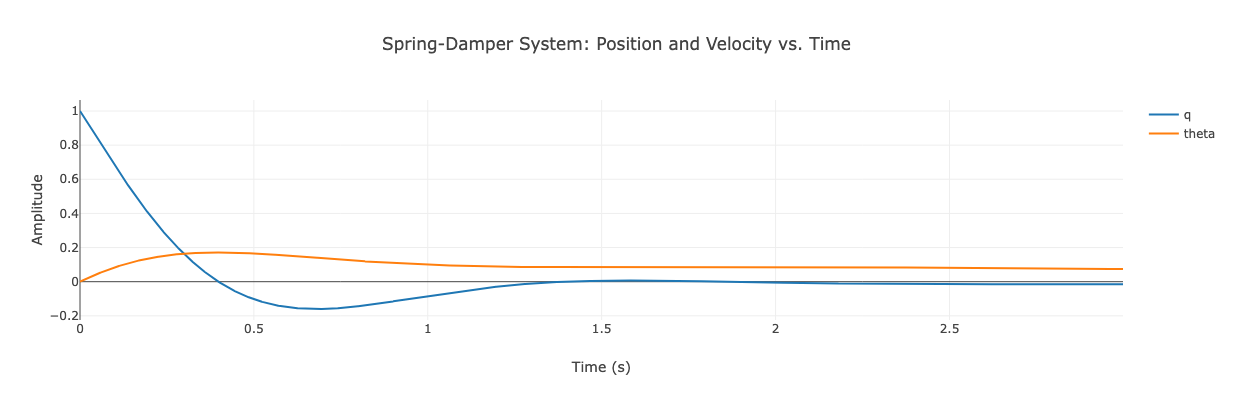

In [45]:
// Extract position and velocity for plotting
let u: Vec<f64> = results.column(0).to_vec();
let w: Vec<f64> = results.column(1).to_vec();
let q: Vec<f64> = results.column(2).to_vec();
let theta: Vec<f64> = results.column(3).to_vec();

use plotly::*;
let mut plot = Plot::new();

// // Plot u vs. time
// let trace_u = Scatter::new(time.clone(), u)
//     .mode(plotly::common::Mode::Lines)
//     .name("u");
// plot.add_trace(trace_u);

// // Plot w vs. time
// let trace_w = Scatter::new(time.clone(), w)
//     .mode(plotly::common::Mode::Lines)
//     .name("w");
// plot.add_trace(trace_w);

// Plot q vs. time
let trace_q = Scatter::new(time.clone(), q)
    .mode(plotly::common::Mode::Lines)
    .name("q");
plot.add_trace(trace_q);

// Plot theta vs. time
let trace_theta = Scatter::new(time.clone(), theta)
    .mode(plotly::common::Mode::Lines)
    .name("theta");
plot.add_trace(trace_theta);

// Set layout properties
let layout = Layout::new()
    .title("Spring-Damper System: Position and Velocity vs. Time")
    .x_axis(plotly::layout::Axis::new().title("Time (s)"))
    .y_axis(plotly::layout::Axis::new().title("Amplitude"))
    .height(400)
    .width(800);

plot.set_layout(layout);
plot.lab_display();